<a href="https://colab.research.google.com/github/viniciosgnr/Trabalho-NewtonRaphson/blob/master/ASP_NEWTON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cmath as cmt 
import math as mt 
import matplotlib.pyplot as plt 
import numpy as np 

In [ ]:
class Newton:
    def __init__(self):
        self.Sbase = 100e6
        self.__dados = dict()
        self.__Sesp = dict()
        self.__Ligacoes = dict()
        self.__ybus = []
        self.__ybus_shunt = []
        self.__J1 = []
        self.__J2 = []
        self.__J3 = []
        self.__J4 = []
        self.__Jacob = []
        self.__listTensao = []
        self.__listAng = []
        self.__fluxoS = dict()
        self.count = 0
        self.__tensaoPlot = dict()
        self.__angPlot = dict()
        self.__x = []
        self.__I = dict()
        self.__V = dict()
        self.__S = dict()
        self.__nPQ = int()
        self.__nPV = int()
        self.__Sbarras = dict()
        self.__ResiduoP = []
        self.__ResiduoQ = []
        self.__deltaPeQ = []
        self.__Perdas = 0

    def setBarras(self, barra, code, tensao, ang, carga, geracao):
        """
        Este método é utilizado apenas para setar (adicionar/atualizar) os valores iniciais de cada barra do
        sistema.
        :param barra: Representa o número de cada barra.
        :param code: Representa o tipo de cada barra (1 : Tensão e Ângulo; 2 : P e Q; 3 : P e V).
        :param tensao: Módulo da tensão na barra.
        :param ang: Valor do ângulo de fase cada barra. Colocá-lo em GRAUS. 
        :param carga: P e Q de carga em cada barra.
        :param geracao: P e Q de geração em cada barra.

        :return: Este método não retorna nada. Apenas modifica/seta os valores para o algoritmo. 
        """
        self.__dados[barra] = {'code': code, 'tensao': tensao, 'ang': mt.radians(ang),
                               'carga': (carga / self.Sbase), 'geracao': (geracao / self.Sbase)}
        self.__tensaoPlot[barra] = [tensao]
        self.__angPlot[barra] = [ang]

    def printBarras(self):
        """
        Método utilizado para printar todos os valores em cada barra.
        """
        print('\n\n=============================== DADOS: =================================')
        print('Sbase = ', self.Sbase, ' VA')
        for i in self.__dados:
            print(self.__dados[i])
        print('========================================================================')

    def setSesp(self):
        """
        Método utilizado para calcular a potência especificada em cada barra. Os valores
        são printados automaticamente.
        """
        for i in self.__dados:
            if self.__dados[i]['code'] == 2:
                self.__Sesp[i] = {'Pesp': np.real(self.__dados.get(i)['geracao'] - self.__dados.get(i)['carga']),
                                  'Qesp': float(
                                      np.imag(self.__dados.get(i)['geracao']) - np.imag(self.__dados.get(i)['carga']))
                                  }
            elif self.__dados[i]['code'] == 3:
                self.__Sesp[i] = {'Pesp': np.real(self.__dados.get(i)['geracao'] - self.__dados.get(i)['carga']),
                                  'Qesp': float(
                                      np.imag(self.__dados.get(i)['geracao']) - np.imag(self.__dados.get(i)['carga']))
                                  }
        print('\n\n=============================== Sesp: =================================')
        print(self.__Sesp, ' pu')
        print('========================================================================')

    def ligacoes(self, barra1, barra2, impedancia=None, admitancia=None, carregamento=0):
        """
        Método utilizado para setar as ligações entre cada barra.

        :param barra1: Barra de origem.
        :param barra2: Barra destino.
        :param impedancia: Valor em PU da impedância.
        :param admitancia: Valor em PU da admitância.
        :param carregamento: Valor em Mvar do caregamento da ligação.

        É necessário informar um valor de admitância ou de impedância.
        """
        if impedancia is None:
            impedancia = 1 / admitancia
        elif admitancia is None:
            admitancia = 1 / impedancia
        else:
            return 'ERRO! É NECESSÁRIO INFORMAR O VALOR DE IMPEDÂNCIA OU DE ADMITÂNCIA DA LINHA! '

        self.__Ligacoes[(barra1, barra2)] = {'Impedância': impedancia,
                                             'Admitância': admitancia,
                                             'Carregamento' :carregamento}

    def printLigacoes(self):
        """
        Método utilizado para printar as ligações do circuito.
        """
        print('\n\n====================================== Ligações: =============================================')
        for i in self.__Ligacoes:
            print('Ligação = ', i, '\t', self.__Ligacoes[i])
        print('==============================================================================================')

    def __printYbus(self):
        """
        Método privado utilizado apenas para printar os valores da matriz ybus.
        """
        print('\n\n============================= YBUS: ====================================')
        for i in self.__ybus: print(i)
        print('========================================================================')

    def ybus(self):
        """
        Método utilizado para calcular a matriz ybus. O cálculo é feito com base no que foi
        visto em aula.
        """
        self.__ybus = np.ones((len(self.__dados), len(self.__dados)), dtype=complex)
        self.__ybus_shunt = np.zeros((len(self.__dados), len(self.__dados)), dtype=complex)
        for i in range(len(self.__ybus)):
            lin = []
            lin_shunt = []
            shunt = []
            for j in range(len(self.__ybus)):
                
                
                if i == j:
                    lin.append(0)
                    lin_shunt.append(0)
                else:
                    if self.__Ligacoes.__contains__(tuple([i + 1, j + 1])):
                        lin.append(-self.__Ligacoes.get(tuple([i + 1, j + 1]))['Admitância'])
                        lin_shunt.append(self.__Ligacoes.get(tuple([ i + 1, j + 1]),0)['Carregamento']/(2*self.Sbase))
                        shunt.append(self.__Ligacoes.get(tuple([ i + 1, j + 1]),0)['Carregamento'])

                    elif self.__Ligacoes.__contains__(tuple([j + 1, i + 1])):
                        lin.append(-self.__Ligacoes.get(tuple([j + 1, i + 1]))['Admitância'])
                        lin_shunt.append(self.__Ligacoes.get(tuple([ j + 1, i + 1]),0)['Carregamento']/(2*self.Sbase))
                        shunt.append(self.__Ligacoes.get(tuple([ j + 1, i + 1]),0)['Carregamento'])
                    else:
                        lin.append(0)
                        lin_shunt.append(0)
            for j in range(len(self.__ybus)):
                if i == j:
                    lin[j] = (-1 * sum(lin)) + (sum(shunt)/(2*self.Sbase))
            self.__ybus[i] = lin
            self.__ybus_shunt[i] = lin_shunt

        self.__printYbus()
        print('\n\n============================= YBUS_Shunt: ====================================')
        for i in self.__ybus_shunt: print(i)
        print('========================================================================')


        for i in self.__dados:
            if self.__dados.get(i)['code'] == 2:
                self.__nPQ += 1
            elif self.__dados.get(i)['code'] == 3:
                self.__nPV += 1

    def Sinjetada(self):
        """
        Método utilizado para calcular as potências injetadas no circuito . 
        E seta os valores de delta P e de delta Q.
        """
        self.__Sinjetada = dict()
        self.__deltaPeQ = []
        self.__ResiduoP = []
        self.__ResiduoQ = []

        for i in self.__dados:
            soma1 = []
            soma2 = []
            if self.__dados[i]['code'] != 1:
                for j in self.__dados:
                    soma1.append(  # Apenas Potência ATIVA
                        abs(self.__ybus[i - 1][j - 1]) *
                        abs(self.__dados.get(i)['tensao']) *
                        abs(self.__dados.get(j)['tensao']) *
                        mt.cos(np.angle(self.__ybus[i - 1][j - 1]) - self.__dados.get(i)['ang'] + self.__dados.get(j)[
                            'ang'])
                    )
                    soma2.append(  # Apenas Potência REATIVA
                        -abs(self.__ybus[i - 1][j - 1]) *
                        abs(self.__dados.get(i)['tensao']) *
                        abs(self.__dados.get(j)['tensao']) *
                        mt.sin(np.angle(self.__ybus[i - 1][j - 1]) - self.__dados.get(i)['ang'] + self.__dados.get(j)[
                            'ang']) * 1j
                    )

                self.__ResiduoP.append(np.real(
                    self.__Sesp.get(i)['Pesp'] - sum(soma1)))  # Lista com os valores de cada barra != da barra |V| phi
                if self.__dados[i]['code'] == 2:
                    self.__ResiduoQ.append(np.imag((self.__Sesp.get(i)['Qesp']) * 1j - sum(soma2)))
                    
        print('\n\n==== RESULTADO VETOR "b" P, Q (Linear System) DA ÚLTIMA ITERAÇÃO: ==========')
        print('===============================================================================')
        for i in range(len(self.__ResiduoP)):
            P_temp = self.__ResiduoP[i]
            print('P (mismatch) ' + str(i) + ': ' + str(P_temp))
            self.__deltaPeQ.append(P_temp)
        for i in range(len(self.__ResiduoQ)):
            Q_temp = self.__ResiduoQ[i]
            print('Q (mismatch) ' + str(i) + ': ' + str(Q_temp))
            self.__deltaPeQ.append(Q_temp)  # SEM O j
        print('===============================================================================')

        #for i in self.__deltaPeQ: print(i)

    def __setJ1(self, listAng, nPQ, nPV):
        """
        Método privado utilizado para calcular a submatriz J1 da matriz Jacobiana.

        :param listAng: Lista de ângulos a serem calculados no circuito. (Barras PQ e PV)
        :param nPQ: Número de barras PQ.
        :param nPV: Número de barras PV.
        :return: Retorna a submatriz J1.
        """
        self.__J1 = np.ones((nPQ + nPV, nPQ + nPV))

        mainDiagonal = []
        outDiagonal = []
        for i in listAng:
            soma = []
            for j in range(1, len(self.__dados) + 1, 1):
                if i != j:
                    soma.append(
                        abs(self.__ybus[i - 1][j - 1]) *
                        abs(self.__dados.get(i)['tensao']) *
                        abs(self.__dados.get(j)['tensao']) *
                        cmt.sin(cmt.phase(self.__ybus[i - 1][j - 1]) -
                                self.__dados.get(i)['ang'] +
                                self.__dados.get(j)['ang'])
                    )
            mainDiagonal.append(sum(soma))

        for i in listAng:
            for j in listAng:
                if i != j:
                    outDiagonal.append(
                        -abs(self.__ybus[i - 1][j - 1]) *
                        abs(self.__dados.get(i)['tensao']) *
                        abs(self.__dados.get(j)['tensao']) *
                        cmt.sin(cmt.phase(self.__ybus[i - 1][j - 1]) -
                                self.__dados.get(i)['ang'] +
                                self.__dados.get(j)['ang'])
                    )
        m = 0
        for i in range(len(listAng)):
            # m = 0
            for j in range(len(listAng)):
                if i == j:
                    self.__J1[i][j] = np.real(mainDiagonal[j])
                else:
                    self.__J1[i][j] = np.real(outDiagonal[m])
                    m += 1

        #print("\nJ1 = \n", self.__J1)
        
        return self.__J1

    def __setJ2(self, listTensao, listAng, nPQ, nPV):
        """
        Método privado utilizado para calcular a submatriz J2 da matriz Jacobiana.

        :param listTensao: Lista de tensões a serem calculadas no circuito. (Barras PQ)
        :param listAng: Lista de ângulos a serem calculados no circuito. (Barras PQ e PV)
        :param nPQ: Número de barras PQ.
        :param nPV: Número de barras PV.
        :return: Retorna a submatriz J2.
        """
        self.__J2 = np.ones((nPQ + nPV, nPQ))

        mainDiagonal = []
        outDiagonal = []

        for i in listAng:
            soma = []
            a = 0
            for j in range(1, len(self.__dados) + 1, 1):

                if i != j:
                    soma.append(
                        abs(self.__ybus[i - 1][j - 1]) *
                        abs(self.__dados.get(j)['tensao']) *
                        cmt.cos(cmt.phase(self.__ybus[i - 1][j - 1]) -
                                self.__dados.get(i)['ang'] +
                                self.__dados.get(j)['ang'])
                    )
            a = (2 * abs(self.__dados.get(i)['tensao']) * abs(self.__ybus[i - 1][i - 1]) *
                 cmt.cos(cmt.phase(self.__ybus[i - 1][i - 1]))
                 )
            mainDiagonal.append(a + sum(soma))

        for i in listAng:
            for j in listTensao:
                if i != j:
                    outDiagonal.append(
                        abs(self.__ybus[i - 1][j - 1]) *
                        abs(self.__dados.get(i)['tensao']) *
                        cmt.cos(cmt.phase(self.__ybus[i - 1][j - 1]) -
                                self.__dados.get(i)['ang'] +
                                self.__dados.get(j)['ang'])
                    )
        m = 0
        for i in range(nPQ + nPV):
            for j in range(nPQ):
                if i < nPV:
                    self.__J2[i][j] = np.real(outDiagonal[m])
                    m += 1
                elif i >= nPV:
                    if i - nPV == j:
                        self.__J2[i][j] = np.real(mainDiagonal[j + nPV])
                    else:
                        self.__J2[i][j] = np.real(outDiagonal[m])
                        m += 1
        #print("\nJ2 = \n", self.__J2)
        
        return self.__J2

    def __setJ3(self, listTensao, listAng, nPQ, nPV):
        """
        Método privado utilizado para calcular a submatriz J3 da matriz Jacobiana.

        :param listTensao: Lista de tensões a serem calculadas no circuito. (Barras PQ)
        :param listAng: Lista de ângulos a serem calculados no circuito. (Barras PQ e PV)
        :param nPQ: Número de barras PQ.
        :param nPV: Número de barras PV.
        :return: Retorna a submatriz J3.
        """
        self.__J3 = np.ones((nPQ, nPQ + nPV))

        mainDiagonal = []
        outDiagonal = []
        for i in listAng:
            soma = []
            for j in range(1, len(self.__dados) + 1, 1):
                if i != j:
                    soma.append(
                        abs(self.__ybus[i - 1][j - 1]) *
                        abs(self.__dados.get(i)['tensao']) *
                        abs(self.__dados.get(j)['tensao']) *
                        cmt.cos(cmt.phase(self.__ybus[i - 1][j - 1]) -
                                self.__dados.get(i)['ang'] +
                                self.__dados.get(j)['ang'])
                    )
            mainDiagonal.append(sum(soma))
        for i in listAng:
            for j in listAng:
                if i != j:
                    outDiagonal.append(
                        -abs(self.__ybus[i - 1][j - 1]) *
                        abs(self.__dados.get(i)['tensao']) *
                        abs(self.__dados.get(j)['tensao']) *
                        cmt.cos(cmt.phase(self.__ybus[i - 1][j - 1]) -
                                self.__dados.get(i)['ang'] +
                                self.__dados.get(j)['ang'])
                    )
        m = 0
        # print('\nmainDiagonal = ', mainDiagonal)
        # print('\noutDiagonal = ', outDiagonal)

        for i in range(nPQ):
            for j in range(nPQ + nPV):
                if j < nPV:
                    self.__J3[i][j] = np.real(outDiagonal[m])
                    m += 1
                elif j >= nPV:
                    if j - nPV == i:
                        self.__J3[i][j] = np.real(mainDiagonal[i + nPV])
                    else:
                        self.__J3[i][j] = np.real(outDiagonal[m])
                        m += 1
        #print("\nJ3 = \n", self.__J3)

        return self.__J3

    def __setJ4(self, listTensao, listAng, nPQ, nPV):
        """
        Método privado utilizado para calcular a submatriz J4 da matriz Jacobiana.

        :param listTensao: Lista de tensões a serem calculadas no circuito. (Barras PQ)
        :param listAng: Lista de ângulos a serem calculados no circuito. (Barras PQ e PV)
        :param nPQ: Número de barras PQ.
        :param nPV: Número de barras PV.
        :return: Retorna a submatriz J4.
        """
        self.__J4 = np.ones((nPQ, nPQ))

        mainDiagonal = []
        outDiagonal = []
        for i in listAng:
            soma = []
            a = 0
            for j in range(1, len(self.__dados) + 1, 1):
                if i != j:
                    soma.append(
                        abs(self.__ybus[i - 1][j - 1]) *
                        abs(self.__dados.get(j)['tensao']) *
                        cmt.sin(cmt.phase(self.__ybus[i - 1][j - 1]) -
                                self.__dados.get(i)['ang'] +
                                self.__dados.get(j)['ang'])
                    )
            a = (2 * abs(self.__dados.get(i)['tensao']) * abs(self.__ybus[i - 1][i - 1]) *
                 cmt.sin(cmt.phase(self.__ybus[i - 1][i - 1]))
                 )
            mainDiagonal.append(-a - sum(soma))
        for i in listAng:
            for j in listTensao:
                if i != j:
                    outDiagonal.append(
                        -abs(self.__ybus[i - 1][j - 1]) *
                        abs(self.__dados.get(i)['tensao']) *
                        cmt.sin(cmt.phase(self.__ybus[i - 1][j - 1]) -
                                self.__dados.get(i)['ang'] +
                                self.__dados.get(j)['ang'])
                    )
        m = 0

        # print('\nmainDiagonal = ', mainDiagonal)
        # print('\noutDiagonal = ', outDiagonal)

        for i in range(nPQ):
            for j in range(nPQ):
                if i == j:
                    self.__J4[i][j] = np.real(mainDiagonal[j + nPV])
                else:
                    self.__J4[i][j] = np.real(outDiagonal[m])
                    m += 1

        #print("\nJ4 = \n", self.__J4)

        return self.__J4

    def setJacob(self, listTensao, listAng):
        """
        Método utilizado para calcular a matriz Jacobiana.

        :param listTensao: Lista de tensões a serem calculadas no circuito. (Barras PQ)
        :param listAng: Lista de ângulos a serem calculados no circuito. (Barras PQ e PV)

        Printa a matriz Jacobiana.
        """

        self.__Jacob = []
        self.__listTensao = listTensao
        self.__listAng = listAng
        nXn = len(listTensao) + len(listAng)

        #print('\nself.__listTensão = ', self.__listTensao)
        #print('\nlistTensão = ', listTensao)
        #print('\nself.__listAng = ', self.__listAng)
        #print('\nlistAng = ', listAng)
        
        J1 = self.__setJ1(listAng, self.__nPQ, self.__nPV)  # (nPQ  + nPV) X (nPQ + nPV)
        J2 = self.__setJ2(listTensao, listAng, self.__nPQ, self.__nPV)  # (nPQ  + nPV) X (nPQ)
        J3 = self.__setJ3(listTensao, listAng, self.__nPQ, self.__nPV)  # (nPQ) X (nPQ + nPV)
        J4 = self.__setJ4(listTensao, listAng, self.__nPQ, self.__nPV)  # (nPQ) X (nPQ)

        self.__Jacob = np.zeros((nXn, nXn))

        for i in range(nXn):
            h = []
            k = []
            if i < len(J1):
                for j in range(len(J1[i])): h.append(J1[i][j])
                for j in range(len(J2[i])): h.append(J2[i][j])
                # geral[i] = np.hstack(h)
                self.__Jacob[i] = np.hstack(h)
            elif i >= len(J1):
                m = i - len(J1)
                for j in range(len(J3[m])): k.append(J3[m][j])
                for j in range(len(J4[m])): k.append(J4[m][j])
                # geral[i] = np.hstack(k)
                self.__Jacob[i] = np.hstack(k)

        #print('\n\n==================== MATRIZ JACOBIANA: ===========================')
        #print('\nJ1 = ')
        #for i in J1: print(i)
        #print('\nJ2 = ')
        #for i in J2: print(i)
        #print('\nJ3 = ')
        #for i in J3: print(i)
        #print('\nJ4 = ')
        #for i in J4: print(i)
        #print('\nJACOB = ')
        #for i in self.__Jacob: print(i)
        #print('========================================================================')

    def linearSystem(self):
        """
        Método utilizado para calcular os resultados do sistema linear .
        O sistema é do tipo:
            [delta P delta Q] = [Jacobiana] . [Resultado]
        """
        self.__x = []
        self.__x = np.linalg.solve(self.__Jacob, self.__deltaPeQ)
        deucerto = np.allclose(np.dot(self.__Jacob, self.__x), self.__deltaPeQ)
        print('\n\t\tDEU CERTO? ', deucerto)

        print('\n\n==== RESULTADO VETOR "x" ÂNG,|V| (Linear System) DA ÚLTIMA ITERAÇÃO: ==========')
        print('===============================================================================')
        ang = []
        tens = []
        for i in range(len(self.__x)):
            if i < (self.__nPQ + self.__nPV):
                ang_temp = self.__x[i]
                ang.append(ang_temp)
                print('Ângulo (mismatch) ' + str(i) + ': ' + str(ang_temp*180/np.pi))
            else:
                tens_temp = self.__x[i]
                tens.append(tens_temp)
                print('Tensão (mismatch) ' + str(i) + ': ' + str(tens_temp))
        print('===============================================================================')
        
        m = 0
        for i in range(len(self.__dados)):
            if self.__dados.get(i + 1)['code'] != 1:
                # print('float(np.real(ang[m])) = ', float(np.real(ang[m])))
                self.__dados[i + 1]['ang'] += float(np.real(ang[m]))
                self.__angPlot[i + 1].append(self.__dados[i + 1]['ang']*180/np.pi)
                m += 1
                
        m = 0
        for i in range(len(self.__dados)):
            if self.__dados.get(i + 1)['code'] == 2:
                # print('float(np.real(tens[m])) = ', float(np.real(tens[m])))
                self.__dados[i + 1]['tensao'] += float(np.real(tens[m]))
                self.__tensaoPlot[i + 1].append(self.__dados[i + 1]['tensao'])
                m += 1

    def NovaInjecao(self):
        """
        Método utilizado para calcular o novo valor de Injeção de potência aparente nas
        barras de folga e PV. (P e Q nas de folga e Q nas PV).
        Cálculo feito conforme o passo 9 da aula 13.
        """
        self.__Sbarras = dict()
        for i in self.__dados:
            soma1 = []
            soma2 = []
            if self.__dados[i]['code'] != 2:
                for j in self.__dados:
                    soma1.append(  # Apenas Potência ATIVA
                        abs(self.__ybus[i - 1][j - 1]) *
                        abs(self.__dados.get(i)['tensao']) *
                        abs(self.__dados.get(j)['tensao']) *
                        mt.cos(np.angle(self.__ybus[i - 1][j - 1]) - self.__dados.get(i)['ang'] + self.__dados.get(j)[
                            'ang'])
                    )
                    soma2.append(  # Apenas Potência REATIVA
                        -abs(self.__ybus[i - 1][j - 1]) *
                        abs(self.__dados.get(i)['tensao']) *
                        abs(self.__dados.get(j)['tensao']) *
                        mt.sin(np.angle(self.__ybus[i - 1][j - 1]) - self.__dados.get(i)['ang'] + self.__dados.get(j)[
                            'ang']) * 1j
                    )
            if self.__dados[i]['code'] == 1:
                self.__Sbarras[i] = {'P': np.real(sum(soma1)), 'Q': np.imag(sum(soma2))}
            elif self.__dados[i]['code'] == 3:
                self.__Sbarras[i] = {'P': 0, 'Q': np.imag(sum(soma2))}

        for i in self.__dados:
            if self.__dados[i]['code'] == 1:
                self.__dados[i]['geracao'] = self.__Sbarras.get(i)['P'] + self.__Sbarras.get(i)['Q'] * 1j
            elif self.__dados[i]['code'] == 3:
                self.__dados[i]['geracao'] = np.real(self.__dados.get(i)['geracao']) + self.__Sbarras.get(i)['Q'] * 1j
        # print('self.__Sbarras = \n', self.__Sbarras)

    def solveCircuito(self, erro=None, iteracoes=None, listTensao=None, listAng=None):
        """
        Método genérico utilizado para 'resolver' o circuito.

        :param erro: Valor do erro utilizado para parar as iterações.
        :param iteracoes: Número de iterações que se deseja repetir o cálculo.
            Obs.: Deve-se passar ou um número de iterações ou um número para o erro.
        :param listTensao: Lista de tensões a serem calculadas no circuito. (Barras PQ)
        :param listAng: Lista de ângulos a serem calculados no circuito. (Barras PQ e PV)
        """
        self.__listTensao = listTensao
        self.__listAng = listAng
        self.count = 1
        self.ybus()
        self.Sinjetada()
        self.setJacob(listTensao=self.__listTensao, listAng=self.__listAng)
        self.linearSystem()

        if iteracoes is None and erro is not None:
            pEq = list(map(abs, self.__deltaPeQ))
            teste = list(map(lambda m: True if (m < erro) else False, pEq))
            stop = teste.count(False)
            while True:
                self.Sinjetada()
                self.setJacob(listTensao=self.__listTensao, listAng=self.__listAng)
                self.linearSystem()
                self.count += 1
                pEq = list(map(abs, self.__deltaPeQ))
                teste = list(map(lambda m: True if (m < erro) else False, pEq))
                stop = teste.count(False)
                # print('\n\nstop = ', stop, '\n\n')
                if stop == 0:
                    break
        elif iteracoes is not None and erro is None:
            while self.count < iteracoes:
                self.Sinjetada()
                self.setJacob(listTensao=self.__listTensao, listAng=self.__listAng)
                self.linearSystem()
                self.count += 1
                pEq = list(map(abs, self.__deltaPeQ))
                teste = list(map(lambda m: True if (m < erro) else False, pEq))
                stop = teste.count(False)

        self.NovaInjecao()
        # self.printBarras()
        if iteracoes is not None:
            print('\n======================= N° DE ITERAÇÕES = ', self.count)
        elif erro is not None:
            print('CONVERGIU PARA UM ERRO DE ', erro, ' .')
            print('CONVERGIU EM ', self.count, ' ITERAÇÕES. ')

    def __printTensao(self):
        """
        Método utilizado para printar os valores das tensões em cada barra. Em pu.
        """
        print('============================ TENSÕES: =======================================')
        for i in self.__dados:
            #print('Barra: \t', i, '\tTensão = ', self.__dados.get(i)['tensao'], ' [pu] // ', 'Ângulo = ', self.__dados.get(i)['ang']*180/np.pi, ' [graus]')
            print(str(i) + ';' + str(self.__dados.get(i)['tensao']) + ';' + str(self.__dados.get(i)['ang']*180/np.pi) + ';')
        print('===============================================================================')

    def Tensoes(self, print=None):
        """
        Método utilizado para calcular as tensões em cada barra.
        O cálculo é feito a partir dos valores em pu e dos ângulos das tensões, os quais são
        oriundos das iterações do método "solveCircuito()".

        :param print: Caso dejese-se mostrar os valores das tensões em cada barra, deve-se passar
        True para o parâmetro "print".
        """
        self.__V = dict()
        for i in self.__dados:
            self.__V[i] = cmt.rect(self.__dados.get(i)['tensao'],
                                   self.__dados.get(i)['ang'])
        if print:
            self.__printTensao()

    def __printCorrentes(self):
        """
        Método utilizado para printar as correntes em cada ligação.
        """
        print('============================ CORRENTES: =======================================')
        for i in self.__I:
            I_temp = self.__I.get(i)
            mI = abs(I_temp)
            aI = np.angle(I_temp)
            #print('Ligação: ', i, ' Corrente = ', mI, ' [pu] // ', 'Ângulo = ', aI*180/np.pi, ' [graus]')
            print(str(i) + ';' + str(mI) + ';' + str(aI*180/np.pi) + ';')
        print('===============================================================================')

    def Correntes(self, print=None):  # Correntes calculadas considerando os ângulos das tensões.
        """
        Método utilizado para calcular os valores das correntes em cada linha.
        O cálculo é feito para todas as barras. Portanto, nas barras que não há ligação,
        o resultado deve ser 0. As correntes que representam ligações com as mesmas barras,
        seus valores são calculados como o somatório de todas as correntes da barra sob análise.

        :param print: Caso dejese-se mostrar os valores das correntes, deve-se passar
        True para o parâmetro "print".
        """
        self.__I = dict()
        self.Tensoes(print=None)
        for i in self.__dados:
            soma = []
            for j in self.__dados:
                if i == j:
                    continue
                else:
                    self.__I[(i, j)] = ((self.__V.get(i) - self.__V.get(j)) * self.__ybus[i - 1][j - 1]) + (self.__V.get(i)*self.__ybus_shunt[i-1 ][j-1 ])
                soma.append(((self.__V.get(i) - self.__V.get(j)) * self.__ybus[i - 1][j - 1])+ (self.__V.get(i)*self.__ybus_shunt[i - 1][j - 1]))
            self.__I[(i, i)] = sum(soma)
        if print:
            self.__printCorrentes()

    def FluxoS(self, printTensao=None, printCorrentes=None):
        """
        Método responsável por calcular o fluxo de potência em todas as ligações do sistema.
        

        :param printTensao: Caso dejese-se mostrar os valores das tensões em cada barra, deve-se passar
        True para o parâmetro "print".
        :param printCorrentes: Caso dejese-se mostrar os valores das correntes, deve-se passar
        True para o parâmetro "print".
        """
        self.__fluxoS = dict()
        self.Tensoes(print=printTensao)
        self.Correntes(print=printCorrentes)
        for i in self.__I:
            a = i[0]
            self.__fluxoS[i] = -self.__V.get(a) * np.conjugate(self.__I.get(i))
        print('======================== Fluxo de Potência: ===================================')
        for i in self.__fluxoS:
            S_temp = self.__fluxoS.get(i)
            P_temp = np.real(S_temp)
            Q_temp = np.imag(S_temp)
            #print('Ligação: ', i, ' P = ', P_temp, ' [pu] // ', 'Q = ', Q_temp, ' [pu]')
            print(str(i) + ';' + str(P_temp) + ';' + str(Q_temp) + ';')
        print('===============================================================================')
        for i in self.__dados:
            if self.__dados.get(i)['code'] != 2:
                self.__dados[i]['geracao'] = -self.__fluxoS.get((i, i))

    def Perdas(self):
        """
        Método utilizado para calcular as perdas do circuito.
        O cálculo é realizado pela soma de todas as potências, conforme o passo 10 da aula 13.
        """
        self.__Perdas = 0
        perdas = []
        for i in self.__fluxoS:
            perdas.append(self.__fluxoS.get(i))
        self.__Perdas = sum(perdas)
        print('\n\nPerdas = \t', self.__Perdas, '\t[pu]')

    def __plotTensao(self):
        """
        Método privado utilizado apenas para plotar a convergência da tensão.
        """
        x = self.count
        barras = []
        y = []
        for i in self.__dados:
            if self.__dados.get(i)['code'] == 2:
                barras.append(i)
        for i in barras:
            y.append(self.__tensaoPlot.get(i))
        for i in range(len(barras)):
            plt.subplot(len(barras), 1, i + 1)
            plt.plot(range(x + 1), y[i])
            plt.title('Variação da tensão na barra ' + str(barras[i]) + ' X Número de iterações')
            plt.xlabel('Número de iterações ')
            plt.ylabel('V' + str(barras[i]) + ' [pu]')
            plt.grid(True)
        plt.tight_layout()
        plt.show()

    def __plotAng(self):
        """
        Método privado utilizado apenas para plotar a convergência do ângulo das tensões nas barras.
        """
        x = self.count
        barras = []
        y = []
        for i in self.__dados:
            if self.__dados.get(i)['code'] != 1:
                barras.append(i)
        for i in barras:
            y.append(self.__angPlot.get(i))
        for i in range(len(barras)):
            plt.subplot(len(barras), 1, i + 1)
            plt.plot(range(x + 1), y[i])
            plt.title('Variação do ângulo na barra ' + str(barras[i]) + ' X Número de iterações')
            plt.xlabel('Número de iterações ')
            plt.ylabel(r'$\theta$' + str(barras[i]) + ' [graus]')
            plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plotDados(self, tensao=None, ang=None):
        """
        Método utilizado para plotar a convergência das tensões e dos ângulos calculados pelo algoritmo.

        :param tensao: Para plotar a tensão, deve-se passar "True" para este parâmetro.
        :param ang: Para plotar o ângulo, deve-se passar "True" para este parâmetro.
        """
        if tensao:
            self.__plotTensao()
        if ang:
            self.__plotAng()

In [ ]:

_5Barras = Newton()
_5Barras.setBarras(1, 1, 1.04, 0, 65e6 + 30e6 * 1j, 0 + 0 * 1j)
_5Barras.setBarras(2, 2, 1.00, 0, 115e6 + 60e6 * 1j, 0 + 0 * 1j)
_5Barras.setBarras(3, 3, 1.02, 0, 70e6 + 40e6 * 1j, 180e6 + 0 * 1j)
_5Barras.setBarras(4, 2, 1.00, 0, 70e6 + 30e6 * 1j, 0 + 0 * 1j)
_5Barras.setBarras(5, 2, 1.00, 0, 85e6 + 40e6 * 1j, 0 + 0 * 1j)




In [ ]:
_5Barras.printBarras()  # Método utilizado para printar os valores atuais nas barras.



=============================== DADOS: =================================
Sbase =  100000000.0  VA
{'code': 1, 'tensao': 1.04, 'ang': 0.0, 'carga': (0.65+0.3j), 'geracao': 0j}
{'code': 2, 'tensao': 1.0, 'ang': 0.0, 'carga': (1.15+0.6j), 'geracao': 0j}
{'code': 3, 'tensao': 1.02, 'ang': 0.0, 'carga': (0.7+0.4j), 'geracao': (1.8+0j)}
{'code': 2, 'tensao': 1.0, 'ang': 0.0, 'carga': (0.7+0.3j), 'geracao': 0j}
{'code': 2, 'tensao': 1.0, 'ang': 0.0, 'carga': (0.85+0.4j), 'geracao': 0j}


In [ ]:
_5Barras.setSesp()  # Método utilizado para setar os valores Especificados de Potência em cada barra



=============================== Sesp: =================================
{2: {'Pesp': -1.15, 'Qesp': -0.6}, 3: {'Pesp': 1.1, 'Qesp': -0.4}, 4: {'Pesp': -0.7, 'Qesp': -0.3}, 5: {'Pesp': -0.85, 'Qesp': -0.4}}  pu


In [ ]:
_5Barras.ligacoes(1, 2, impedancia=0.042 + 0.168j,carregamento = 4.1e6 * 1j)
_5Barras.ligacoes(1, 5, impedancia=0.031 + 0.126j,carregamento = 3.1e6 * 1j)
_5Barras.ligacoes(2, 3, impedancia=0.031 + 0.126j,carregamento=3.1e6 * 1j)
_5Barras.ligacoes(3, 4, impedancia=0.084 + 0.336j,carregamento=8.2e6 * 1j)
_5Barras.ligacoes(3, 5, impedancia=0.053 + 0.21j,carregamento = 5.1e6 * 1j)
_5Barras.ligacoes(4, 5, impedancia=0.063 + 0.252j,carregamento = 6.1e6 * 1j)

In [ ]:
_5Barras.printLigacoes()  # Método utilizado para printar as ligações do sistema.




====================================== Ligações: =============================================
Ligação =  (1, 2) 	 {'Impedância': (0.042+0.168j), 'Admitância': (1.4005602240896358-5.602240896358543j), 'Carregamento': 4100000j}
Ligação =  (1, 5) 	 {'Impedância': (0.031+0.126j), 'Admitância': (1.8411831086298034-7.483518441527588j), 'Carregamento': 3100000j}
Ligação =  (2, 3) 	 {'Impedância': (0.031+0.126j), 'Admitância': (1.8411831086298034-7.483518441527588j), 'Carregamento': 3100000j}
Ligação =  (3, 4) 	 {'Impedância': (0.084+0.336j), 'Admitância': (0.7002801120448179-2.8011204481792715j), 'Carregamento': 8200000j}
Ligação =  (3, 5) 	 {'Impedância': (0.053+0.21j), 'Admitância': (1.1298471508665715-4.476752861924151j), 'Carregamento': 5100000j}
Ligação =  (4, 5) 	 {'Impedância': (0.063+0.252j), 'Admitância': (0.9337068160597572-3.734827264239029j), 'Carregamento': 6100000j}


In [ ]:
_5Barras.solveCircuito(iteracoes=None, listTensao=[2, 4,5], listAng=[2,3,4,5], erro=1e-3)



============================= YBUS: ====================================
[ 3.24174333-13.04975934j -1.40056022 +5.6022409j
  0.         +0.j          0.         +0.j
 -1.84118311 +7.48351844j]
[-1.40056022 +5.6022409j   3.24174333-13.04975934j
 -1.84118311 +7.48351844j  0.         +0.j
  0.         +0.j        ]
[ 0.         +0.j         -1.84118311 +7.48351844j
  3.67131037-14.67939175j -0.70028011 +2.80112045j
 -1.12984715 +4.47675286j]
[ 0.        +0.j          0.        +0.j         -0.70028011+2.80112045j
  1.63398693-6.46444771j -0.93370682+3.73482726j]
[-1.84118311 +7.48351844j  0.         +0.j
 -1.12984715 +4.47675286j -0.93370682 +3.73482726j
  3.90473708-15.62359857j]


============================= YBUS_Shunt: ====================================
[0.+0.j     0.+0.0205j 0.+0.j     0.+0.j     0.+0.0155j]
[0.+0.0205j 0.+0.j     0.+0.0155j 0.+0.j     0.+0.j    ]
[0.+0.j     0.+0.0155j 0.+0.j     0.+0.041j  0.+0.0255j]
[0.+0.j     0.+0.j     0.+0.041j  0.+0.j     0.+0.0305j]
[0

In [ ]:
 _5Barras.FluxoS(printTensao=True, printCorrentes=True)

============================ TENSÕES: =======================================
1;1.04;0.0;
2;0.9613940886100658;-6.322315930272057;
3;1.02;-3.71327305582636;
4;0.9202482086506213;-10.886085461005312;
5;0.9682674737079727;-6.161101219539523;
============================ CORRENTES: =======================================
(1, 2);0.7911448361607742;154.0520893461862;
(1, 3);0.0;0.0;
(1, 4);0.0;0.0;
(1, 5);1.0046193641375534;156.322013692562;
(1, 1);1.7954168713866094;155.32198948128786;
(2, 1);0.7761144820419287;-23.16110961818455;
(2, 3);0.560960555110979;-42.392010941494604;
(2, 4);0.0;0.0;
(2, 5);0.0;0.0;
(2, 2);1.3187802767713215;-31.214996414878012;
(3, 1);0.0;0.0;
(3, 2);0.5801274854754335;135.1986925474549;
(3, 4);0.4748784348400856;142.95416667267764;
(3, 5);0.3255366501274035;134.9913723672366;
(3, 3);1.3776336445875144;137.81581418628684;
(4, 1);0.0;0.0;
(4, 2);0.0;0.0;
(4, 3);0.4406689322284889;-28.062944524961566;
(4, 5);0.34572303823205164;-21.640965259846208;
(4, 4);0.78517537

In [ ]:
_5Barras.Perdas()



Perdas = 	 (0.19354127920398978+1.3492861041524897j) 	[pu]


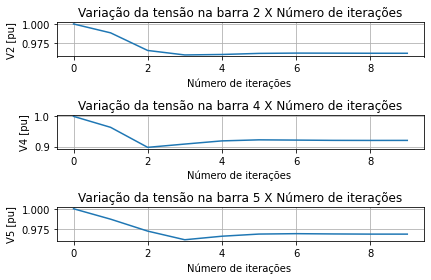

In [ ]:
_5Barras.plotDados(tensao=True, ang=False)

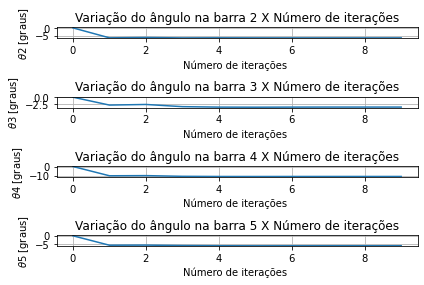

In [ ]:
_5Barras.plotDados(tensao=False, ang=True)